In [1]:
import numpy as np
import matplotlib.pyplot as plt
seed = 1923
print (f"User seed is set to {seed}")

User seed is set to 1923


In [2]:
print ("""Make sure to check later which 
    functions you can use and which you have to write yourself""")
print ("\n")

Make sure to check later which 
    functions you can use and which you have to write yourself




In [3]:
# Some routines of which I am not sure we can just use
# Thus coded up below
# I assume very elementary math such as summing (np.sum) and 
# raising to a power (np.pow) can just be used. 

def linspace(lower,upper,numpoints):
    """
    Generate 'numpoints' equally spaced between 'lower' and 'upper'
    i.e., replacement of np.linspace
    """
    
    dx = (upper-lower)/(numpoints-1)
    point = lower
    ans = [point]
    for i in range(1,numpoints-1):
        point += dx
        ans.append(point)
    ans.append(upper)
    return np.asarray(ans)

def logspace(lower,upper,numpoints):
    """
    Generate 'numpoints' equally spaced on a log scale.
    i.e., replacement of np.logspace
    
    In linear space sequence starts at 10**(start) and ends at 10**(end)
    This function simply raises 10 to the power linspace
    """
    return np.power(10,linspace(lower,upper,numpoints))

def findmin(array):
    """
    Find minimum of array-like object 'array'
    """
    minimum = array[0]
    for i in range(1,len(array)):
        if array[i] < minimum:
            minimum = array[i]
            
    return minimum

def findmax(array):
    """
    Find maximum of array-like object 'array'
    """
    maximum = array[0]
    for i in range(1,len(array)):
        if array[i] > maximum:
            maximum = array[i]
            
    return maximum
    

# Question 1 Preparing some useful routines

Floats can be much larger numbers than integers
so we could simply use a numpy.float64 to calculate factorials 
up to 170!
But for the bonus point, we have to be a little more clever.

We don't need the final value of 200!, but only the ratio of 
$\lambda^k / k! $

We can calculate the poisson prob as exp of the log of the poisson prob
so 
$$ \frac{\lambda^k}{k!}\mathcal{e}^{-\lambda} = \exp\left( \log \left( \frac{\lambda^k}{k!} \mathcal{e}^{-\lambda} \right) \right) $$

and 
$$ \log \left( \frac{\lambda^k}{k!} \mathcal{e}^{-\lambda} \right) = k\log(\lambda)-\log(k!) -\lambda$$

and the logarithm turns multiplications into sums of logarithms, so this is what we can use to calculate the log.

e.g., $\log (3!) = \log(3)+\log(2) + \log(1) = \log(3)+\log(2)$


In [4]:
def log_kfac(k):
    """
    Calculate the logarithm of the factorial of k
    """
    if k == 0:
        return 0

    ans = np.log(k)
    for x in range(2,int(k)):
        ans += np.log(x)
    return ans

def poisson_probability(k,lambd):
    """
    Returns the Poisson probability, i.e., the probability of 'k' 
    occurences if 'lambd' is the occurence rate, per interval. 
    
    k can be a list or np.array
    """

    lambd = np.float64(lambd) # limit memory
        
    if type(k) == np.ndarray or type(k) == list:
        k = np.asarray(k,dtype='float64') # limit memory
        
        logkfac = []
        for i in range(0,len(k)): # iterate over the array-like object
            logkfac.append(log_kfac(k[i]))
    else:
        k = np.float64(k) # limit memory, assume k is now a float
        logkfac = log_kfac(k)
    
    return np.exp(k*np.log(lambd) - logkfac - lambd)


## Output $P_{\lambda}(k)$ to at least 6 significant digits for following values

In [5]:
# Output P_{\lambda}(k) to at least 6 significant digits for these values
lambdas = [1,5,3,2.6]
ks = [0,10,20,40]

for k, lambd in zip(ks, lambdas):
    print(f'P_{lambd}({k}) = {poisson_probability(k,lambd):.5e}')
            
lambd, k = 101, 200 # For bonus points
print(f'P_{lambd}({k}) = {poisson_probability(k,lambd):.5e}')

P_1(0) = 3.67879e-01
P_5(10) = 1.81328e-02
P_3(20) = 7.13538e-11
P_2.6(40) = 3.61512e-33
P_101(200) = 1.26953e-18


### Write a random number generator that returns a random floating-point number between 0 and 1. At minimum, use some combination of an (M)LCG and a 64-bit XOR-shift

In [6]:
class RandomGenerator(object):
    """
    Random generator should be an object because it maintains
    internal state between calls.
    """
    def __init__(self, seed):
        # make sure the everyhing is an unsigned 64 bit integer
        dtyp = np.uint64
        # the seed for the LGC
        self.X1 = dtyp(seed)
        # the seed for the XORshift
        self.X2 = dtyp(seed)
        
        self.max_value = dtyp(2**64 - 1)
        
        # LCG values from Numerical Recipies
        self.a = dtyp(1664525)
        self.c = dtyp(1013904223)
        self.m = dtyp(2**32)
        
        # 64 bit XOR shift values from Numerical Recipies
        self.a1, self.a2, self.a3 = dtyp(21), dtyp(35), dtyp(4)
        
    def lincongen(self, X):    
        return (self.a*X+self.c) % self.m

    def XORshift64(self, X):
        if X == 0:
            raise ValueError("Seed cannot be zero")
        X = X ^ (X >> self.a1)
        X = X ^ (X << self.a2)
        X = X ^ (X >> self.a3)
        
        return X
    
    def get_randomnumber(self):
        """
        Combine LCG and XORshift to produce random float 
        between 0 and 1
        """
        self.X1 = self.lincongen(self.X1)
        self.X2 = self.XORshift64(self.X2)
        
        # output is XOR of these numbers
        
        return (self.X1^self.X2)/self.max_value
    
        


In [7]:
RNGESUS = RandomGenerator(seed=seed)

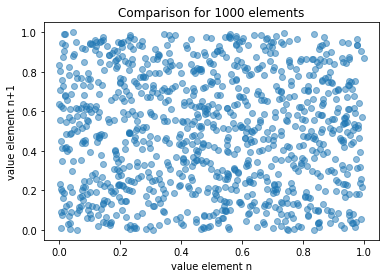

In [8]:
all_randnum = []
for i in range(1000):
    # Could vectorize? 
    all_randnum.append(RNGESUS.get_randomnumber())
    
plt.plot(all_randnum,np.roll(all_randnum,1),'o',alpha=0.5)
plt.title(f'Comparison for {len(all_randnum)} elements')
plt.xlabel('value element n')
plt.ylabel('value element n+1')
plt.savefig('q1b1.png')
plt.show();

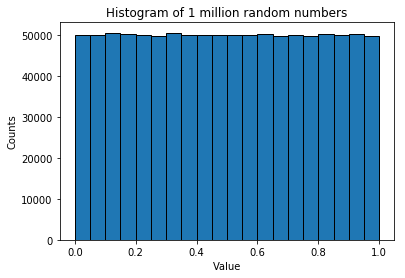

In [9]:
all_randnum = []
for i in range(int(1e6)):
    all_randnum.append(RNGESUS.get_randomnumber())
    
plt.hist(all_randnum,bins=linspace(0,1,21),edgecolor='black')
plt.title(f'Histogram of 1 million random numbers')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.savefig('q1b2.png')
plt.show();

# Question 2

In [10]:
def densprofile(x, a, b, c, A=1, Nsat = 100, spherical=False):
    """
    Returns the density profile from the assignment
    
    a controls small-scale slope
    b contols transition scale
    c controls steepness of exponential dropoff
    spherical -- True to multiply by x**2 for the spherical integral
    """
    if spherical:
        power = 1
    else:
        power = 3
        
    return A*Nsat * (x/b)**(a-power) * np.exp( -(x/b)**c )

In [11]:
def romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae
    
    efficiency:
    http://homen.vsb.cz/~lud0016/NM/Lecture_Notes_10-Romberg_Integration.pdf
    
    Returns 
     Value of the integral
     Error estimate
     
    The error estimate is given as the difference between last 2 orders
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = linspace(lbound,ubound,2**i+1)
        # add new points to the integral (om en om, starting from 1)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # columns
        for i in range(j,order): # rows
            #print (i,j)
            #print (f'{4**j}*S{i},{j-1} - S{i-1},{j-1} / {4**j} - 1' )
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j - 1)

    # compare this for the error function with the slides. 
    # print (all_S)
    
    return all_S[order-1,order-1], (all_S[order-1,order-1]-all_S[order-1,order-2])
        


In [12]:
# Randomly generate a,b,c within asked bounds
a = RNGESUS.get_randomnumber()*(2.5-1.1) + 1.1
b = RNGESUS.get_randomnumber()*(2.0-0.5) + 0.5
c = RNGESUS.get_randomnumber()*(4-1.5) + 1.5

# integral is only a function of R so add the prefactor manually
prefactor = 4*np.pi # integral over theta and phi
Nsat = 100
print ("For the following ")
print (f'a, b, c = {a,b,c}')
# print ("Romberg integration gives:")
integ, error = romberg(lambda x: densprofile(x, a, b, c, Nsat=Nsat
                        , spherical=True) , 0, 5,order=10)
integ *= prefactor
# Normalize such that the integral produces <Nsat>
A = Nsat/integ
print (f"We find A = {A}")

integ, error = romberg(lambda x: densprofile(x, a, b, c, A, Nsat=Nsat
                        , spherical=True) , 0, 5,order=10)

For the following 
a, b, c = (1.3879482885811734, 1.9278450364977295, 2.901790176457339)
We find A = 0.06469019845387262


### b) Make a loglog plot of and plot single points for n(1e-4), n(1e-2), n(1e-1), n(1) and n(5)

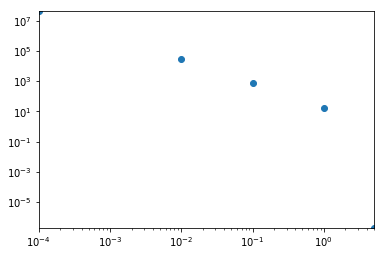

In [13]:
points = np.array([1e-4, 1e-2, 1e-1, 1, 5])
function = lambda x: densprofile(x,a,b,c,A=A,Nsat=Nsat,spherical=False)
ypoints = function(points)
plt.scatter(points,ypoints)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,5)
plt.ylim(ypoints[-1],ypoints[0])
plt.show();

In [14]:
def linear_interpolation(x, f, num_values, begin, end, logx=False):
    """
    Interpolate given 'x' values and function 'f' at 
    'num_values' linearly separated between 'begin' and 'end'
    if logx = True, use equal width x values in logspace
    
    The function always takes all x in linear space.
    Whether y is logspace is determined by the function 'f' 
    
    """
    # y values of the points that are given
    y = f(x)
    # interpolated y values
    y_values = []
    # interpolated x values
    if logx:
        # equal width in log space
        x_values = logspace(np.log10(begin),np.log10(end),num_values)
        # fit in log(x) space
        x_values = np.log(x_values)
        x = np.log(x)
    else:
        # fit in linear space
        x_values = linspace(begin,end,num_values)
    
    # Interpolation
    for i in range(len(x)-1):
        # calculate slope between two points
        a = ( y[i+1] - y[i] ) / (x[i+1] - x[i])
        # take only x values between two points
        x_values_now = x_values[(x_values >= x[i]) & (x_values < x[i+1])]
        # calculate y values as linear interpolation
        y_values += list(y[i] + (x_values_now - x[i])*a)
        
    # Extrapolation, is simply extrapolating final bin
    x_values_now = x_values[(x_values >= x[i+1])]
    y_values += list(y[i] + (x_values_now - x[i])*a)
    
    return x_values, np.asarray(y_values)

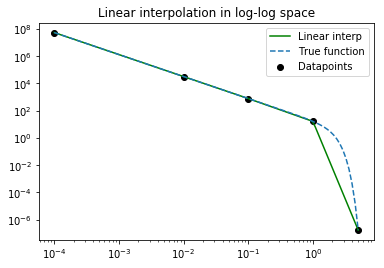

In [15]:
# # Fit a linear model to the function in log-log space
# function = lambda x: densprofile(x,a,b,c,A=A,Nsat=Nsat
#                                      ,spherical=False)
# points = np.array([1e-4, 1e-2, 1e-1, 1, 5])
# logfunc = lambda x: np.log(function(x))

# x_interp, y_interp = linear_interpolation(points,logfunc
#                             , 100, 1e-4, 5, logx=True)
# # Transform back to linear space
# x_interp = np.exp(x_interp)
# y_interp = np.exp(y_interp)

# ypoints = function(points)

# plt.plot(x_interp,y_interp,
#             label='Linear interp',c='g')
# plt.plot(x_interp, function(x_interp),label='True function', ls='dashed')
# plt.scatter(points,ypoints, c='k',label='Datapoints')
# plt.legend()
# plt.title('Linear interpolation in log-log space')
# plt.xscale('log')
# plt.yscale('log')
# plt.savefig('./linear_interpolation.png')
# plt.show();

In [16]:
def recurrence_relation(i, j, x, all_x, f,logx=False):
    """
    Neville's algorithm recurrence relation
    i,j -- int   -- index of the datapoints 
    x   -- float -- x value to evaluate
    all_x -- array -- data points x
    f   -- function -- function that calculates y(x)
    """
    if i == j:
        # return y_i
        if logx:
            return f(np.exp(all_x[i]))
        else:
            return f(all_x[i])
    else:
        # return the recursive relation
        return ( ((x - all_x[j])*recurrence_relation(i, j-1, x, all_x, f, logx) 
         - (x-all_x[i])*recurrence_relation(i+1, j, x, all_x, f,logx)) /
        (all_x[i] - all_x[j]) ) 

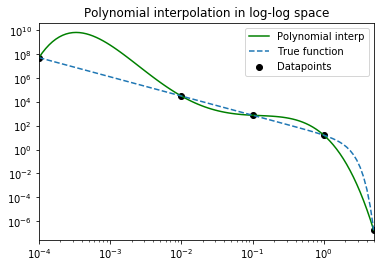

In [17]:
# Polynomial model to the function in log-log space

function = lambda x: densprofile(x,a,b,c,A=A,Nsat=Nsat
                                     ,spherical=False)
points = np.array([1e-4, 1e-2, 1e-1, 1, 5])
logfunc = lambda x: np.log(function(x))

# Nevilles method for 100 datapoints 
# x values to interpolate in log space
x_interp_pol = np.log(logspace(np.log10(1e-4), np.log10(5), 100))
# y values calculated according to Neville's
y_interp_pol = [recurrence_relation(0,len(points)-1, x_interp_pol[i], 
            np.log(points), logfunc, logx=True) 
            for i in range(len(x_interp_pol)) ]

# Transform back to normal space
x_interp = np.exp(x_interp_pol)
y_interp = np.exp(y_interp_pol)

# Datapoints
ypoints = function(points)

plt.plot(x_interp,y_interp, label='Polynomial interp',c='g')
plt.plot(x_interp, function(x_interp)
         ,label='True function', ls='dashed')
plt.scatter(points,ypoints, c='k',label='Datapoints')
plt.legend()
plt.title('Polynomial interpolation in log-log space')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,5)
plt.savefig('./poly_interpolation.png')
plt.show();

REMOVE TRUE FUNCTION LATER


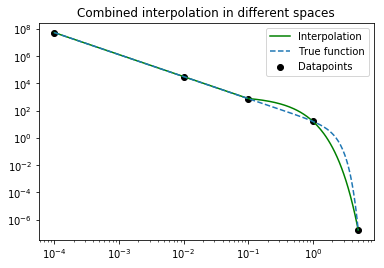

In [18]:
# Now combine the methods for the final result
"""
# Log-log space is the preferred space for the start of the function
because if we take the logarithm
of both sides, the expression becomes 
log(n) \propto log(x)- x^c

So in log log space, for x<1 we have an approx linear function 
log(n) \approx K * log(x)

And for x>1 we have an exponential function, so we fit this
in log-lin space with Neville's algorithm.
In this space we have approximately
log(n) \approx K * x^c

So, since c will be somewhere between 1.5 and 4, a quadratic
polynomial is a best guess. Thus we fit a polynomial of order 2
between last 3 datapoints with Nevilles algorithm
"""
# Linearly interpolate between first 3 datapoints
# Nevilles method between last 3


function = lambda x: densprofile(x,a,b,c,A=A,Nsat=Nsat
                                     ,spherical=False)
logfunc = lambda x: np.log(function(x))
points = np.array([1e-4, 1e-2, 1e-1, 1, 5])
ypoints = function(points)

# Linear interpolation, 100 datapoints between first 3 datapoints
x_interp_lin, y_interp_lin = linear_interpolation(points[:3],logfunc
                            , 100, 1e-4, 1e-1, logx=True)

# Nevilles method for 100 datapoints between last 3 datapoints
# x in linear space, y in logspace
x_interp_pol = logspace(np.log10(1e-1), np.log10(5), 100)
y_interp_pol = [recurrence_relation(0,len(points)-3, x_interp_pol[i], 
            points[2:], logfunc, logx=False) 
            for i in range(len(x_interp_pol)) ]

# Combine them and transform to first x half to lin space
# and both y halves to lin space for plotting
x_interp = np.append(np.exp(x_interp_lin),x_interp_pol)
y_interp = np.exp(np.append(y_interp_lin,y_interp_pol))

print ("REMOVE TRUE FUNCTION LATER")
plt.plot(x_interp,y_interp,
            label='Interpolation',c='g')
plt.plot(x_interp, function(x_interp),label='True function', ls='dashed')
plt.scatter(points,ypoints, c='k',label='Datapoints')
plt.legend()
plt.title('Combined interpolation in different spaces')
plt.xscale('log')
plt.yscale('log')
plt.savefig('./combined_interpolation.png')
plt.show();

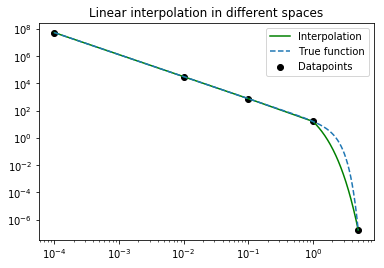

In [19]:
# Linear fit in log-log space followed by linear in log-lin space
# This only works if c is near 1, which is not neccessarily the case

function = lambda x: densprofile(x,a,b,c,A=A,Nsat=Nsat
                                     ,spherical=False)
logfunc = lambda x: np.log(function(x))
points = np.array([1e-4, 1e-2, 1e-1, 1, 5])
ypoints = function(points)

# Linear interpolation, 100 datapoints between first 4 datapoints
x_interp_lin, y_interp_lin = linear_interpolation(points[:4],logfunc
                            , 100, 1e-4, 1, logx=True)

# Linear method between last 2 datapoints in log-lin space
x_interp_lin2, y_interp_lin2 = linear_interpolation(points[3:],logfunc
                            , 100, 1, 5, logx=False)

# Combine them, transform x to linear space
x_interp = np.append(np.exp(x_interp_lin),x_interp_lin2)
y_interp = np.append((y_interp_lin),y_interp_lin2)


plt.plot(x_interp,np.exp(y_interp),
            label='Interpolation',c='g')
plt.plot(x_interp, function(x_interp),label='True function', ls='dashed')
plt.scatter(points,ypoints, c='k',label='Datapoints')
plt.legend()
plt.title('Linear interpolation in different spaces')
plt.xscale('log')
plt.yscale('log')
plt.savefig('./double_linear_interpolation.png')
plt.show();

In [20]:
# Cubic spline tbd
# print (A,Nsat,a,b,c)

### c) Numerically calculate dn(x)/dx at x=b

In [21]:
def anal_deriv(x,a,b,c,A,Nsat):
    """Analytical derivative of density profile"""
    return ( (a-3-c*(x/b)**c) * (x**(a-4))* np.exp( -(x/b)**c ) 
        *A*Nsat/(b**(a-3)) )

In [22]:
def central_difference(func, x, h):
    """
    calculate numerical derivative with central difference method
    
    """
    return (func(x+h) - func(x-h)) / (2*h)

In [23]:
def ridders_method(func, x, d, m, target_error):
    """
    func -- function to calculate numerical derivative for
    x -- position at which it is calculated
    d -- factor with which h of the central difference is reduced
    m -- highest order we will go to
    target_error -- target error
    """
    
    # for saving the error, one value per column # (Mean error)
    error = []
    # for saving D_i,j's
    all_D = np.zeros((m,m))
    
    # First approximation
    h = 0.1
    all_D[0,0] = central_difference(func, x, h)
    
    # Then calculate the first column (D{i,0})
    for i in range(m):
        h /= d
        all_D[i,0] = central_difference(func, x, h)
    
    # Then calculate all others by combining
    for j in range(1,m): # columns
        for i in range(j,m): # rows
            #print (i,j)
            #print (f'{4**j}*S{i},{j-1} - S{i-1},{j-1} / {4**j} - 1' )
            all_D[i,j] = (d**(2*(j+1)) * all_D[i,j-1] - all_D[i-1,j-1]) / (
                           d**(2*(j+1)) - 1)
        error.append(np.abs(all_D[i,j]-all_D[i,j-1]))
        if error[-1] < target_error:
#             print (f"Target error of {target_error} reached at D_{i,j}")
            return all_D[i,j], error
        if len(error) > 2:
            if error[-1] > error[-2]:
#                print (f"Error increased at at D_{i,j}")
                # error increased, should stop
                return all_D[i,j], error

    return all_D[m-1,m-1], error

In [24]:
print (f"dn(x)/dx at x=b={b}")
ridder, error = ridders_method(function, b, d=2, m=15, target_error=1e-15)
print(f'Numerical derivative: {ridder:.12f}')

analderiv = anal_deriv(b,a,b,c,A,Nsat)
print(f'Analytical derivative: {analderiv:.12f}')


dn(x)/dx at x=b=1.9278450364977295
Numerical derivative: -5.572091280844
Analytical derivative: -5.572091280900


### d) Now we want to generate 3D satellite positions such that they statistically follow the profile. That is, the probaility of x $\in$ [0,x_max] should be p(x)dx = $n(x)4\pi x^2 dx / <Nsat>$. Use one of the methods discussed in classs to sample this distribution. Additionally, for each galaxy generate random angles $\phi$ and $\theta$ such that the resulting positions are uniformly distributed as a function of direction (uniform on a sphere). Output the positions (r,$\phi$,$\theta$) for 100 such satellites

In [25]:
def pdfRadii(x, a, b, c, A):
    """
    PDF for question 2d
    """
    # Set Nsat = 1 so we effectively divide by Nsat
    return ( densprofile(x,a,b,c,A,Nsat=1,spherical=True) * 4*np.pi)

In [26]:
# Rejection sampling
def rejection_sampling(RNG, pdf, x_begin, x_end, num_points=500):
    """
    Sample num_points from the PDF by rejection sampling
    
    RNG -- random number generator that generates number \in [0,1]
    pdf -- pdf of the function to sample from: y(x)
    num_points -- amount of points to sample
    x_begin, x_end -- begin and endpoint of uniform dist sample
    """
        
    all_x = []
    factor = x_end-x_begin
    while len(all_x) < num_points:
        x = RNG()*(factor)+x_begin 
        y = RNG()
        if y <= pdf(x):
            all_x.append(x)
    
    return all_x

In [27]:
RNG = RNGESUS.get_randomnumber # random number generator func

#### Thus, random numbers on a sphere
The surface area of a sphere: $dA = rd\theta * r sin\theta d\phi$ reduces in size near the poles ($\theta$ near 0 or $\pi$). Thus we can draw $\phi$ (the azimuthal angle) from a uniform distribution between 0 and $2\pi$, but not $\theta$. From the total area of a sphere being $4\pi$ we can find $\theta$ has pdf: 

$\mathcal{f}$($\theta$) = $1/2 * sin\theta$. 


So we can use selection sampling to sample $\theta$, since we know

$\theta = \arcsin (2*y)$

Or better: Inverse transform sampling, where we use the CDF of this distribution:
$F(\theta) = 1/2(1-cos(\theta) )$

and the inverse of this:

$\theta = F^{-1}(u) = \arccos(1-2u) )$

In [28]:
def inverse_transform_sample(RNG, invcdf, num_points=500):
    """
    Sample num_points from the CDF with inverse transform sampling
    
    RNG -- random number generator that generates number \in [0,1]
    invcdf -- inverse CDF of the function to sample from
    num_points -- amount of points to sample
    """   
    
    all_x = []
    for _ in range(num_points):
        u = RNG()
        x = invcdf(u)
        all_x.append(x)
        
    return all_x

In [29]:
def invcdf(u):
    """Inverse CDF of \theta"""
    return np.arccos(1-2*u)

In [30]:
def output_N_satellites(RNG, pdf, N):
    """
    Generate N satellites following the density profile
    given as 'pdf'
    
    We assume 
    0<=x<=5, 0<=\phi<2\pi, 0<= theta <= \pi
    
    Inputs
    RNG -- a function that will generate x ~ unif[0,1] when called
    pdf -- the PDF to generate the data from
    N -- number of satellites
    """
    
    # Generate x with rejection sampling,
    # because we cannot invert or integrate the PDF
    all_x = rejection_sampling(RNG, pdf, 0, 5, N) # x = r/rvir

    # Generate theta with inverse transform sampling
    # because integrating and inverting is very easy
    all_theta = inverse_transform_sample(RNG, invcdf, N)
    
    # Generate phi with just uniform numbers between 0 and 2pi
    all_phi = []
    for i in range(N):
        all_phi.append(RNG())
    all_phi = np.array(all_phi)*2*np.pi

    return all_x, all_theta, all_phi
    
# Output the positions for 100 such satellites, with current a,b,c
thispdf = lambda x: pdfRadii(x,a,b,c,A)
all_x, all_theta, all_phi = output_N_satellites(RNG,thispdf,N=100)
# print (all_x,all_phi,all_theta)

np.array([all_x,all_theta,all_phi]).shape

(3, 100)

In [31]:
# # Just to show that it worked

# Just to show that it works
# x_values = linspace(0,5,1000)
# plt.hist(all_x,alpha=0.5,label='Rejection sampling',density=True)
# plt.plot(x_values, pdfRadii(x_values),label='pdf',c='C1')
# plt.legend()
# plt.show()


# all_x = np.array(all_x)
# all_theta = np.array(all_theta)
# x_coord = 1 * np.sin(all_theta)*np.cos(all_phi)
# y_coord = 1 * np.sin(all_theta)*np.sin(all_phi)
# z_coord = 1 * np.cos(all_theta)

# from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x_coord,y_coord,z_coord)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.savefig('./test.png')
# plt.show()

# linspace_theta = linspace(0,np.pi)
# plt.plot(linspace_theta, np.sin(linspace_theta)/2)
# plt.hist(all_theta,alpha=0.5,density=True)
# plt.show()

# plt.hist(all_phi,density=True)
# plt.show()

### e) Repeat (d) for 1000 halos

In [32]:
# A thousand halos with 100 satellites
all_all_x, all_all_theta, all_all_phi = [], [], []
for i in range(1000):
    all_x, all_theta, all_phi = output_N_satellites(RNG,thispdf, N=100)
    all_all_x.append(all_x)
    all_all_theta.append(all_theta)
    all_all_phi.append(all_phi)
    
all_all_x = np.asarray(all_all_x)

In [33]:
def plot_loghistogram(data, bins, density=False):
    """
    Plot loglog histogram
    data -- array-like object to plot
    bins -- bins to divide it into
    density -- whether to normalize by bin width
    """
    
    bin_centers = (bins[:-1] + bins[1:])/2
    binwidths = (bins[1:] - bins[:-1])
    
    # I dont know if this is required
    
    

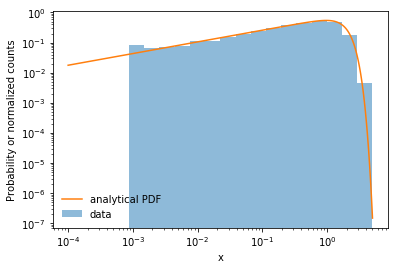

In [34]:
xs = linspace(1e-4,5,100)

# Generate 20 logarithmically equal spaced bins between 1e-4 and 5
bins = logspace(np.log10(1e-4),np.log10(5),21)

# Plot it as histogram
nperbin, _, _ = plt.hist(all_all_x.flatten(), bins=bins
                         ,alpha=0.5,label='data')
plt.close() # We could also set density is true, but since I am unsure
# whether this is allowed, we shall normalize it manually.

bin_centers = (bins[:-1] + bins[1:])/2
binwidths = (bins[1:] - bins[:-1])
# Divide each bin by its width
# And divide by the total count to normalize
nperbin /= binwidths*np.sum(nperbin)

# Normalized histogram
plt.bar(bin_centers,nperbin,binwidths,label='data',alpha=0.5)
# Analytical function
plt.plot(xs, thispdf(xs),label='analytical PDF',c='C1') # plot N(x)=n(x)*4pi*x^2

plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Probability or normalized counts')
plt.yscale('log')
plt.xscale('log')
plt.show()


In [35]:
# The galaxies match the distribution very well

### F) Write a root finding algorithm to find the solutions to N(x) = y/2 in x $\in$ [0,xmax], where y is the maximum of N(x). Use the same parameters as before and output the roots

In [36]:
def position_of_maxNx(a,b,c):
    """
    Analytical formula for position x of the maximum of 
    N(x) = n(x)*4pi*x^2, given a b and c
    """
    return b*( (a-1)/c )**(1/c)

In [37]:
def false_position(func, lower, upper, acc, MAX=100):
    """
    Fit secant lines through two points to approximate the root
    Update points such that the root remains bracketed
    
    func -- function to approximate the root of
    lower -- first abcissa point of initial guess 
    uppper -- second abcissa point of initial guess 
    acc -- target accuracy
    MAX -- maximum number of iterations before function stops
    
    Returns
    x1,x2 -- two points that bracket the root
    i+1   -- number of iterations done
    """
    
    ylower, yupper = func(lower), func(upper)
    
    if ylower * yupper >= 0:
        raise ValueError("Incorrect starting bracket")
    # smallest function value is 'most recent' guess = x2
    if abs(ylower) <= abs(yupper):
        x2 = lower
        x1 = upper
    else:
        x2 = upper
        x1 = lower
    
    for i in range(MAX):        
        # new value
        x3 = x1 - ( func(x1)*(x1-x2)  / (func(x1) - func(x2)) )
        # update values, most recent guess is two values that bracket
        if func(x3)*func(x2) <= 0: 
            # if new point has different sign, then update last point
            x1 = x2
        else:
            x1 = x1
        x2 = x3
        
        if abs(x1 - x2) < acc:
            break
        
    return x1, x2, i+1

In [38]:
print (f'a, b, c = {a,b,c}')

# Use analytical formula to find the maximum
xmax = position_of_maxNx(a,b,c)
ymax = thispdf(xmax)

# Then use root finding to find where the function-ymax/2 is 0
function = lambda x: thispdf(x) - ymax/2

# Secant is not a good option, because we will likely diverge 
# Due to the linear approximation not being very good
# Therefore, we use the false position method, since it will not diverge

acc = 1e-8
# First root will be between starting value and x of the maximum
xlower1, xupper1, itneeded1 = false_position(function, 1e-4,xmax,acc)
# Second root will be x of the maximum and 5
xlower2, xupper2, itneeded2 = false_position(function, xmax,5, acc)

best_guess1 = (xlower1+xupper1)/2
best_guess2 = (xlower2+xupper2)/2
print (f"First root is approximately at {best_guess1}")
print (f"{itneeded1} iterations were needed")

print (f"Second root is approximately at {best_guess2}")
print (f"{itneeded2} iterations were needed")

# print ("\nDifference with analytical:")
# print (thispdf(best_guess1)-ymax/2)
# print (thispdf(best_guess2)-ymax/2)

a, b, c = (1.3879482885811734, 1.9278450364977295, 2.901790176457339)
First root is approximately at 0.11444760929762551
68 iterations were needed
Second root is approximately at 1.9983059524256035
9 iterations were needed


### g) Take the radial bin from (e) containing the largest number of galaxies. Using sorting, calculate the median, 16th and 84th percentile in this radial bin and output these values. Next, make a histogram of the number of galaxies in this radial bin in each halo (so we get 1000 values), and each bin should have a width of 1. Plot the histogram and over-plot the poisson distribution using (a). with $\lambda$ = mean number of galaxies in this radial bin

In [39]:
def find_position_maximum(array):
    """
    Given a 1D array-like object, finds the index of the max value
    
    returns imax -- the index of the maximum value in the array
    """
    maximum = array[0]
    imax = 0
    for i in range(1,len(array)):
        if array[i] > maximum:
            maximum = array[i]
            imax = i
            
    return imax

max_n = find_position_maximum(nperbin)
print ("Maximum bin", max_n)
print ("Which is between x's:")
print (bins[max_n:max_n+2])
# Bin containing largest number of galaxies

Maximum bin 16
Which is between x's:
[0.57434918 0.98656227]


In [40]:
def selection_sort(arr):
    """
    Sort a 1D array-like object with selection sort
    Even though it is returned, array is sorted in place!
    """
    N = len(arr)
    # for every position in the array     
    for i in range(0,N-1):
        # Find next smallest element     
        imin = i
        for j in range(i+1, N):
            if arr[j] < arr[imin]:
                imin = j
        # put it in the correct position by swapping with current i
        if imin != i:
            arr[imin], arr[i] = arr[i], arr[imin]
    return arr

def quicksort(arr):
    """
    Sort array with quicksort
    sorting is performed IN PLACE
    """
    N = len(arr)
    
    # Make sure first/last/middle elements are ordered correctly
    if arr[0] > arr[N-1]: # swap leftmost and rightmost elements
        arr[0], arr[N-1] = arr[N-1], arr[0]
    if arr[(N-1)//2] > arr[N-1]: # swap middle and rightmost element
        arr[(N-1)//2], arr[N-1] = arr[N-1], arr[(N-1)//2]
    if arr[0] > arr[(N-1)//2]: # swap middle and leftmost element
        arr[0], arr[(N-1)//2] = arr[(N-1)//2], arr[0]
    
    i, j = 0, N-1
    pivot = arr[(N-1)//2]
    pivot_position = (N-1)//2
    for _ in range(0,N//2): # Can improve this range()
        while arr[i] < pivot:
            i +=  1
        while arr[j] > pivot:
            j -= 1
        if j <= i:
            break # pointers have crossed
        else:
            if i == pivot_position: # have to keep track of where the pivot is
                pivot_position = j # going to switch them
            elif j == pivot_position:
                pivot_position = i
            # Both i and j found, swap them around the pivot and continue
            arr[i], arr[j] = arr[j], arr[i]
    
    if N > 2:
        # As long as we don't have 1 element arrays, perform quicksort on the subarrays
        leftarr = arr[:pivot_position] # left of the pivot
        rightarr = arr[pivot_position+1:] # right of the pivot        
        quicksort(leftarr)
        quicksort(rightarr)

In [41]:
# Have to calculate the median of x and 16 and 84th percentile?
# Or have to calculate the median number of galaxies per halo?
# I think the first, so find all x's within this bin

# boundaries of the bin
lower_x = bins[max_n]
upper_x = bins[max_n+1]
# Shape (1000,?) of the x values of the satellites per halo
# that are in the specified bin
halo_satellites_in_bin = []
for i in range(0,all_all_x.shape[0]):
    satellites_in_bin = []
    for j in range(0,all_all_x.shape[1]):
        if all_all_x[i,j] > lower_x and all_all_x[i,j] < upper_x:
            satellites_in_bin.append(all_all_x[i,j])
    halo_satellites_in_bin.append(satellites_in_bin)
    
# Dont know if we are allowed to concatenate
total_satellites_in_bin = np.concatenate(halo_satellites_in_bin)

print (len(total_satellites_in_bin))

21731


In [42]:
# %time sorted_satellites_in_bin = selection_sort(np.copy(total_satellites_in_bin))

quicksort(total_satellites_in_bin)

CPU times: user 1min 29s, sys: 43.6 ms, total: 1min 30s
Wall time: 1min 32s
CPU times: user 249 ms, sys: 968 µs, total: 250 ms
Wall time: 257 ms


In [43]:
def give_percentile(sorted_arr, percentile):
    """
    Percentile defined with midpoint interpolation
    """
    N = len(sorted_arr)
    index = percentile/100 * (N-1)
    if index == int(index):
        return sorted_arr[int(index)]
    else:
        index = int(index)
        return (sorted_arr[index] + sorted_arr[index+1])/2
            


In [44]:
median = give_percentile(total_satellites_in_bin,50)
sixteent = give_percentile(total_satellites_in_bin, 16)
eightyfth = give_percentile(total_satellites_in_bin, 84)

print (f"Median {median}")
print (f"16th {sixteent}")
print (f"84th {eightyfth}")

Median 0.7845411079474811
16th 0.6429710432699716
84th 0.9217318256086829


In [45]:
# Now make a histogram of the number of galaxies in this radial bin
# in each halo. 

# In each halo, stores the number of satellites in the specified bin
num_satellites_bin = [] # shape (1000,1)
for halo in range(0,len(halo_satellites_in_bin)):
    # amount of satellites within the specified bin in this halo
    amount_in_bin = (len(halo_satellites_in_bin[halo]))
    num_satellites_bin.append(amount_in_bin)

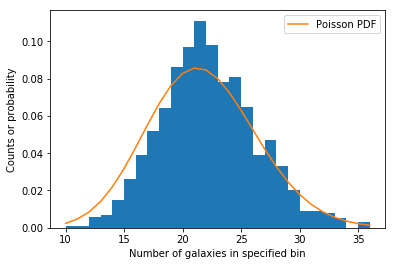

In [46]:
# Each bin should have a width of 1
max_num = findmax(num_satellites_bin)
min_num = findmin(num_satellites_bin)
bins = linspace(min_num, max_num, max_num-min_num+1)

mean_num = np.mean(num_satellites_bin)
poisson_prob = poisson_probability(bins,mean_num)

# Dont know if we are allowed to use density=True
plt.hist(num_satellites_bin,bins=bins, density=True)
plt.plot(bins,poisson_prob,label='Poisson PDF')
plt.xlabel('Number of galaxies in specified bin')
plt.ylabel('Counts or probability')
plt.legend()
plt.show()

### The normalization factor A depends on all three parameters. Calculate A at 0.1 wide intervals in the ranges of a, b and c given above ($\textit{including the boundaries}$). Should get a table containing 6240 values. Choose an interpolation scheme and write a 3D interpolator for A as a fucntion of the three parameters based on these calculated values

In [47]:
a_range = linspace(1.1,2.5,int((2.5-1.1)*10)+1)
b_range = linspace(0.5,2,int((2-0.5)*10)+1)
c_range = linspace(1.5,4,int((4-1.5)*10)+1)

In [48]:
# 3D array to save the results, shape = (15,16,26)
results = np.empty((len(a_range),len(b_range),len(c_range)))
for a_indx in range(0,len(a_range)):
    for b_indx in range(0,len(b_range)):
        for c_indx in range(0,len(c_range)):
            integ, error = romberg(lambda x: densprofile(
                x, a_range[a_indx], b_range[b_indx], c_range[c_indx]
                , Nsat=Nsat, spherical=True) , 0, 5,order=10)
            integ *= prefactor
            # Normalize such that the integral produces <Nsat>
            A = Nsat/integ
            
            results[a_indx,b_indx,c_indx] = A

In [49]:
# TEST JUST TO SEE HOW THE FUNCTION BEHAVES

def test_func():
    plt.scatter(a_range,results[:,0,0])
    plt.title('a=param, b=0.5, c=1.5')
    plt.xlabel('a')
    plt.ylabel('A')
    plt.show()

    plt.scatter(a_range,results[:,-1,-1])
    plt.title('a=param, b=2, c=4')
    plt.xlabel('a')
    plt.ylabel('A')
    plt.show()

    plt.scatter(b_range,results[0,:,0])
    plt.title('a=1.1, b=param, c=1.5')
    plt.xlabel('b')
    plt.ylabel('A')
    plt.show()

    plt.scatter(b_range,results[-1,:,-1])
    plt.title('a=2.5, b=param, c=4')
    plt.xlabel('b')
    plt.ylabel('A')
    plt.show()

    plt.scatter(c_range,results[0,0,:])
    plt.title('a=1.1, b=0.5, c=param')
    plt.xlabel('c')
    plt.ylabel('A')
    plt.show()


    plt.scatter(c_range,results[-1,-1,:])
    plt.title('a=2.5, b=2, c=param')
    plt.xlabel('c')
    plt.ylabel('A')
    plt.show()
    
# test_func()

In [50]:
# Linear interpolation is probably pretty good, as 
# we have a quite regularly sampled the grid
class LinearInterp3D(object):
    """
    Class for linear interpolation in 3D using regular grid input data
    Arguments:
    points -- the regular spaced grid [x_values,y_values,z_values]
              assumes these points are given in ascending order
              and at regular intervals of 0.1
              
    values -- the values corresponding to the regular spaced grid
    
    __call__ -- call with coordinate points (x,y,z) to calculate linear interpolated value
    
    """
    def __init__(self, points, values):
        self.points = points
        self.values = values
        
    def __call__(self, coordinates):
        # Interpolate at single coordinates (x,y,z), assumes these are not on the regular grid
        # Formulas from https://en.wikipedia.org/wiki/Trilinear_interpolation
        
        # Find the cube that bounds the x,y,z value
        indices = self.find_indices(coordinates)
        # Calculate differences
        xd = (coordinates[0]-self.points[0][indices[0]])/(self.points[0][indices[0]+1] - self.points[0][indices[0]])
        yd = (coordinates[1]-self.points[1][indices[1]])/(self.points[1][indices[1]+1] - self.points[1][indices[1]])
        zd = (coordinates[2]-self.points[2][indices[2]])/(self.points[2][indices[2]+1] - self.points[2][indices[2]])
        # Interpolate along x
        c00 = self.values[tuple(indices)]*(1-xd)+self.values[tuple(indices+np.array([1,0,0]))]*xd
        c01 = self.values[tuple(indices+np.array([0,0,1]))]*(1-xd) + self.values[tuple(indices+np.array([1,0,1]))]*xd
        c10 = self.values[tuple(indices+np.array([0,1,0]))]*(1-xd) + self.values[tuple(indices+np.array([1,1,0]))]*xd
        c11 = self.values[tuple(indices+np.array([0,1,1]))]*(1-xd) + self.values[tuple(indices+np.array([1,1,1]))]*xd
        # Interpolate along y
        c0 = c00*(1-yd) + c10*yd
        c1 = c01*(1-yd) + c11*yd
        # Interpolate along z
        c = c0*(1-zd) + c1*zd
        return c
        
    def find_indices(self, coordinates):
        """
        Find 3 indices in array points that define the lower bound
        of the box that bounds the coordinates
        We use the fact that we know the points are spaced at regular
        intervals of length 0.1
        """
        indices = []
        for i in range(3):
            indices.append( int( (coordinates[i]-self.points[i][0])/0.1 ) )
        return np.asarray(indices)
        

In [51]:
linInterp = LinearInterp3D([a_range,b_range,c_range],results)

In [52]:
# Example of how to interpolate a point: 
linInterp([1.41,0.65,2.57]) 

0.19543438951617328

# 3. Now we are going to turn things around
# Download satgals_m11 to m15. Each file contains halos in a certain mass bin with variable numbers of satellites. Write down the log-likelihood correpsonding to a set of random realizations of the satellite profile in equation (2) with some unkown $<N_{sat}>$. Retain only the terms with a (residual) dependence on a,b, and/or c. Including A=A(a,b,c)

#### The log-likelihood (log=ln) for a set of N i.i.d. realizations of eq. (2):
$$ \log \mathcal{L}(\theta) \propto N \log[A(a,b,c)] + (a-1)\sum_{i=0}^{N-1} \log(x_i/b) - \sum_{i=0}^{N-1}(x_i/b)^c $$

gives 

$$ \log \mathcal{L}(\theta) \propto N \log[A(a,b,c)] + (a-1) \left( - N\log(b) + \sum_{i=0}^{N-1} \log(x_i) \right) - b^{-c}\sum_{i=0}^{N-1}(x_i)^c $$


which can also be written as

$$ \log \mathcal{L}(\theta) \propto \\ N \log[A(a,b,c)] + (a-1) \left( {\displaystyle \log(\prod_{i=0}^{N-1} x_i)} - N\log(b) \right) - b^{-c}\sum_{i=0}^{N-1}(x_i)^c $$

The last formula is not numerically stable, because calculating the product of all the $x_i$ introduces roundoff errors quickly. So we use the one to last formula


### a) Find the a, b and c that maximize this likelihood. Do this seperately for each different file/mass bin

In [53]:
# Thus we have to minimize the negative log-likelihood. 

# Better: Just calculate the sum of log(x_i) once
# then give that to this function since that will not change
def neglogL(a,b,c,xi,sumlogxi):
    """
    Returns the negative log likelihood for a set of N i.i.d. 
    realizations x_i, given parameters a,b,c
    
    Takes the sum of the logarithm of xi values as well
    because this can be calculated once upfront for a single file.
    This removes the unnecessary calculation of this value 
    every time we evaluate neglogL for certain a,b,c
    
    """
    N = len(xi)
    
    if (not(1.1 < a <2.5) or not(0.5 < b < 2) or not(1.5 < c < 4)):
        # a b or c is not in required bound, return high number
        return 1e6
    
    # We use the trilinear interpolator to approximate A(a,b,c)
    A = linInterp([a,b,c])
    
    second_term = sumlogxi
    second_term -= N*np.log(b)
    
    # Dont know if we are allowed to use np.sum
    return -1* ( N*np.log(A) + (a-1)*second_term - b**(-c) * np.sum(xi**c) )

In [54]:
def calc_centroid(vectors):
    """
    Given an array 'vectors' of shape (len(points),Ndim)
    calculate the centroid (i.e., mean over every dimension)
    """
    centroid = np.empty(vectors.shape[1])
    for i in range(vectors.shape[1]):
        centroid[i] = np.mean(vectors[:,i])
        
    return centroid

def selection_argsort(arr):
    """
    Return indices that would sort array
    Needed for downhill simplex function. 
    Since the number of points is usually low, we can just use 
    selection sort.
    """
    N = len(arr)
    indices = list(range(0,N))
    # for every position in the array     
    for i in range(0,N-1):
        # Find next smallest element     
        imin = i
        for j in range(i+1, N):
            if arr[indices[j]] < arr[indices[imin]]:
                imin = j
        # put it in the correct position by swapping with current i
        if imin != i:
            indices[imin], indices[i] = indices[i], indices[imin]
    return indices

def downhill_simplexND(func,start,delta,tol=2e-10,maxIter=20):
    """
    Find minimum of N-D function.
    
    func -- function to minimize (has to take x,y,.., as arguments)
    start -- vector of length N with the initial starting point
    delta -- guess for the characteristic length scale of the problem
    
    Returns
    x0 -- best guess for the minimum of the function
    vertices -- all vertices around the minimum
    it -- number of iterations done
    """
    N = len(start)
    it = 0
    
    # A vertex in N-D has N+1 points
    # First construct the other N points
    vertices = [start]
    for i in range(0,N):
        basis_vector = np.zeros(N)
        basis_vector[i] = 1
        vertices.append(start + basis_vector*delta)
        
    vertices = np.array(vertices) # array of shape (N+1,N)
    
    for _ in range(maxIter):
        it += 1
        
        # Order the points such that x0 is the minimum, xN is maximum
        order = selection_argsort([func(*vertice) for vertice in vertices])
        vertices = vertices[order]

        # Calculate the centroid of the first N points
        centroid = calc_centroid(vertices[:N])

        # Check if fractional range in func is within target acc
        fracrange = 2*abs(func(*vertices[-1]) - func(*vertices[0])) / (
                    abs(func(*vertices[-1]) + func(*vertices[0])) )
        if fracrange <= tol:
            # best guess x0, return all vertices too, and num iterations
            return vertices[0], vertices, it
        
        # Otherwise, propose a new point by reflecting xN
        x_try = 2*centroid - vertices[-1]

        # There are now four distinct possibilities:
        if func(*vertices[0]) <= func(*x_try) < func(*vertices[-1]):
            # new point is better, but not the best. We accept it
            vertices[-1] = x_try # Set new x_{N}
        elif func(*x_try) < func(*vertices[0]):
            # new point is the best, expand further in this direction
            x_exp = 2*x_try - centroid
            if func(*x_exp) < func(*x_try):
                # then expansion was even better
                vertices[-1] = x_exp
            else:
                # expansion did not work
                vertices[-1] = x_try
        else: # We know now that f(x_try) was worse than func(x_{N-1})
            # Propose a new point by contracting instead of reflecting
            x_try = 0.5*(centroid+vertices[-1])
            if func(*x_try) < func(*vertices[-1]):
                # Accept the contracted point
                vertices[-1] = x_try # I think this should be vertices[-1]
            else:
                # All options were apparently bad, just zoom in on best
                for i in range(1,N+1):
                    vertices[i] = 0.5*(centroid + vertices[i])

    return vertices[0], vertices, it

In [55]:
def read_in_halos(filename):
    """
    Read in the data for exercise 3, per filename.
    
    First number in the file on line 4 is always the number of halos.
    Then we find hash symbols to indicate a new halo,
    and then we find coordinates of satellites (if any)
    x, phi and theta.
    
    Returns the number of haloes in the datafile
    and the satellite positions divided per halo.
    """
    
    # List of satellite positions x, don't care in which halo they are
    all_satellites = []
    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i == 3:
                num_halos = int(line.strip('\n'))
            
            # i = 4 is always the first halo.
            if i > 4:
                if '#' in line: # Next halo 
                    pass
                else: # append satellite positions
                    coordinates = line.strip('\n').split('  ')
                    # Save only x position, cast to float
                    coordinates = float(coordinates[0])
                    all_satellites.append(coordinates)    
    
    return num_halos, all_satellites
            

In [56]:
# [read_in_halos(f'./satgals_m{i}.txt') for i in [11,12,13,14,15]] 

In [57]:
# for i in [11,12,13,14,15]:
# Start with 14 for now
i=14
num_halos, all_satellites = read_in_halos(f'./satgals_m{i}.txt')

So we just minimize the negative-log likelihood to find the best fitting a,b,c

In [58]:
###### TEST


# # First check if the negative log-likelihood is minimized 
# # for a,b,c that we know
# print (a,b,c)

# xs = linspace(1e-4,5,100)
# bins = logspace(np.log10(1e-4),np.log10(5),21)

# nperbin, _, _ = plt.hist(all_all_x.flatten(), density=True, bins=bins
#          ,alpha=0.5,label='data')


# plt.plot(xs, pdfRadii(xs),label='analytical PDF')
# # plot N(x)=n(x)*4pi*x^2
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

# # Function to minimize
# minfunc = lambda x, y, z: neglogL(x,y,z,xi=all_all_x.flatten())

# print ("First implementation")
# %timeit neglogL(a,b,c,all_all_x.flatten())
# print (neglogL(a,b,c,all_all_x.flatten()))

# print ("Second implementation")
# %timeit negLogL_test(a,b,c,all_all_x.flatten())
# print (negLogL_test(a,b,c,all_all_x.flatten()))

# # Temp saving of a,b,c
# a_save, b_save, c_save = 1.1132884107646899, 1.250296832286201, 1.7885721190002482

# # Best guess scipy optimize
# a,b,c = np.array([1.10000002, 1.99999947, 3.86556342])


# xs = linspace(1e-4,5,100)
# bins = logspace(np.log10(1e-4),np.log10(5),21)

# nperbin, _, _ = plt.hist(all_all_x.flatten(), density=True, bins=bins
#          ,alpha=0.5,label='data')


# plt.plot(xs, pdfRadii(xs),label='analytical PDF') 
# # plot N(x)=n(x)*4pi*x^2
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

# a,b,c = a_save, b_save, c_save
# # Best guess simplex
# best_guess, vertices, it = (downhill_simplexND(minfunc
#                         ,[a+0.1,b+0.1,c+0.1],0.1
#                           ,tol=2e-10,maxIter=2000))

# print ("Best guess simplex")
# print ("best guess",best_guess)

# a,b,c = best_guess
# # Best guess simplex
# xs = linspace(1e-4,5,100)
# bins = logspace(np.log10(1e-4),np.log10(5),21)

# nperbin, _, _ = plt.hist(all_all_x.flatten(), density=True, bins=bins
#          ,alpha=0.5,label='data')

# plt.plot(xs, pdfRadii(xs),label='analytical PDF') 
# # plot N(x)=n(x)*4pi*x^2
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()



# a,b,c = a_save, b_save, c_save


In [59]:
"""
There seems to be a problem for certain a,b,c with the generation of
all_all_x, rerun the program for several seeds later..

Or my rejection sampling is wrong. 
"""

'\nThere seems to be a problem for certain a,b,c with the generation of\nall_all_x, rerun the program for several seeds later..\n\nOr my rejection sampling is wrong. \n'

In [60]:
# We minimize with the downhill simplex method

# Calculate this upfront for efficiency
sumlogxi = np.sum(np.log(all_satellites))    
# Function to minimize
minfunc = lambda x, y, z: neglogL(x,y,z,all_satellites,sumlogxi)
print (f"Starting at current a,b,c = {a,b,c}")
best, vertices, it = downhill_simplexND(minfunc, [a,b,c]
                                    , 0.01,tol=1e-15,maxIter=500)
print (f"Best guess after {it} iterations: {best}")

Starting at current a,b,c = (1.3879482885811734, 1.9278450364977295, 2.901790176457339)
Best guess after 300 iterations: [1.68213785 0.72399079 3.3       ]


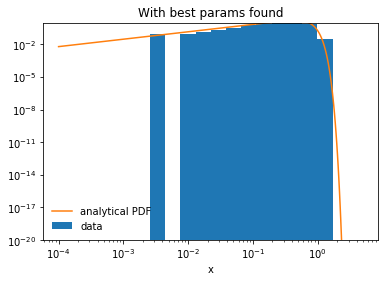

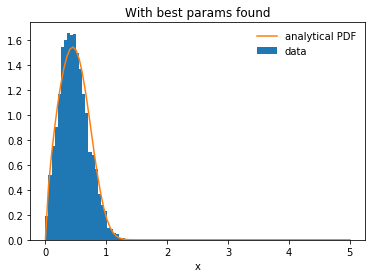

In [61]:
# Plotting the solution
all_x = linspace(1e-4,5,100)
all_x_log = logspace(np.log10(1e-4),np.log10(5),21)

# Calculate A(best) 
A = linInterp(best)

plt.title("With best params found")
# Analytical function
plt.plot(all_x, pdfRadii(all_x,*best,A),label='analytical PDF',c='C1') # plot N(x)=n(x)*4pi*x^2

plt.hist(all_satellites,density=True, bins=all_x_log, label='data')

plt.legend(frameon=False)
plt.xlabel('x')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-20,1e-0)
plt.show()

# Analytical function
plt.title("With best params found")
plt.plot(all_x, pdfRadii(all_x,*best,A),label='analytical PDF',c='C1') # plot N(x)=n(x)*4pi*x^2

nbins, bins, _ = plt.hist(all_satellites,density=True, bins=all_x, label='data')

plt.legend(frameon=False)
plt.xlabel('x')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

#### 3a) Find a,b,c that maximize the likelihood, do this separately for each different file/mass bin. Output the values

In [62]:
def find_abc(i):
    """
    Find a,b,c that maximize the likelihood for mass file 'i'
    i has to be in [11,12,13,14,15]
    """
    num_halos, all_satellites = read_in_halos(f'./satgals_m{i}.txt')
        
    # Calculate this upfront for efficiency
    sumlogxi = np.sum(np.log(all_satellites))  

    # Function to minimize
    minfunc = lambda x, y, z: neglogL(x,y,z,all_satellites,sumlogxi)
    
    # Downhill simplex method
    
    initial_guess = [1.5, 0.7, 2.7] # from eyeballing the data
    best, vertices, it = downhill_simplexND(minfunc, initial_guess
                                        , 0.01,tol=1e-15,maxIter=500)
    return all_satellites, best, it
    

import time
start_time = time.time()
# We minimize with the downhill simplex method

all_best = []
for i in [11,12,13,14,15]:
    all_satellites, best, it = find_abc(i)
    all_best.append(best)
    print (f"Mass file m{i}")
    print (f"Best guess for a,b,c after {it} iterations: {best}")

print (f"Took {time.time()-start_time} seconds")


Mass file m11
Best guess for a,b,c after 168 iterations: [1.46862962 0.97320158 2.5       ]


KeyboardInterrupt: 

In [ ]:
# # For eyeballing the results, delete later


# xvalues = linspace(0,3,101)

# best1 = [1.5,0.97,2.5]
# best2 = [1.5,0.7,3.5]
# best3 = [1.5,0.7,3.5]
# best4 = [1.5,0.7,3.5]
# best5 = [1.5,0.7,3.5]

# all_best_eyeball = [best1,best2,best3,best4,best5]
# for i, ifile in enumerate([11]): #([11,12,13,14,15]):
#     print (f"Doing m{ifile}")
#     best_now_eyeball = all_best_eyeball[i]
#     num_halos, all_satellites = read_in_halos(
#                                 f'./satgals_m{ifile}.txt')

#     A = linInterp(best_now_eyeball)
    
#     fig, axes = plt.subplots(1,2,figsize=(10,6))
    
#     plt.suptitle(f"Best params eyeballed, m{ifile}")
    
#     axes[0].plot(xvalues, pdfRadii(xvalues,*best_now_eyeball,A)
#              ,label='analytical PDF',c='C1')

#     nbins, bins, _ = axes[0].hist(all_satellites,density=True
#                     , bins=linspace(0,5,101), label='data')
    
#     axes[1].plot(xvalues, pdfRadii(xvalues,*best_now_eyeball,A)
#              ,label='analytical PDF',c='C1')

#     nbins, bins, _ = axes[1].hist(all_satellites,density=True
#                     , bins=linspace(0,5,101), label='data')
#     axes[1].set_xscale('log')
#     axes[1].set_yscale('log')
    
#     plt.legend(frameon=False)
#     plt.xlabel('x')
#     # plt.yscale('log')
#     # plt.xscale('log')
#     plt.savefig(f'./eyeball_bestparams_m{ifile}')
#     plt.show()



In [ ]:
# For plotting the results, delete later

# import matplotlib
# matplotlib.rcParams['agg.path.chunksize'] = 10000

xvalues = linspace(0,5,101)
for i, ifile in enumerate([11,12,13,14,15]):
    print (f"Doing m{ifile}")
    best_now = all_best[i]
    num_halos, all_satellites = read_in_halos(
                                f'./satgals_m{ifile}.txt')

    A = linInterp(best_now)
    
    fig, axes = plt.subplots(1,2,figsize=(10,6))
    
    plt.suptitle(f"Best params found, m{ifile}")
    
    axes[0].plot(xvalues, pdfRadii(xvalues,*best_now,A)
             ,label='analytical PDF',c='C1')

    nbins, bins, _ = axes[0].hist(all_satellites,density=True
                    , bins=linspace(0,5,101), label='data')
    
    axes[1].plot(xvalues, pdfRadii(xvalues,*best_now,A)
             ,label='analytical PDF',c='C1')

    nbins, bins, _ = axes[1].hist(all_satellites,density=True
                    , bins=linspace(0,5,101), label='data')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    
    plt.legend(frameon=False)
    plt.xlabel('x')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.savefig(f'./bestparams_m{ifile}')
    plt.show()

#### b) Write an interpolator for a, b and c as a function of halo mass, or fit a function to each. Argue your specific choice. Plot the results

In [ ]:
all_best = np.asarray(all_best)

plt.scatter(range(11,16),all_best[:,0])
plt.title("$a$ as function of halo mass")
plt.xlabel('Halo mass')
plt.ylabel('a')
plt.show()

plt.scatter(range(11,16),all_best[:,1])
plt.title("$b$ as function of halo mass")
plt.xlabel('Halo mass')
plt.ylabel('b')
plt.show()

plt.scatter(range(11,16),all_best[:,2])
plt.title("$c$ as function of halo mass")
plt.xlabel('Halo mass')
plt.ylabel('c')
plt.show()